In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import chain
import scipy
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
##Import any other packages you may need here

Using TensorFlow backend.


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2363,00011972_000.png,No Finding,0,11972,018Y,M,PA,2846,2991,0.143,0.143
832,00004360_002.png,Effusion,2,4360,076Y,M,AP,2500,2048,0.171,0.171
5079,00026994_002.png,Atelectasis|Pneumonia,2,26994,040Y,F,PA,2992,2991,0.143,0.143


In [3]:
## EDA
# Todo
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 5606


## Age 

In [4]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 100]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2aa2a8cdd0>]],
      dtype=object)

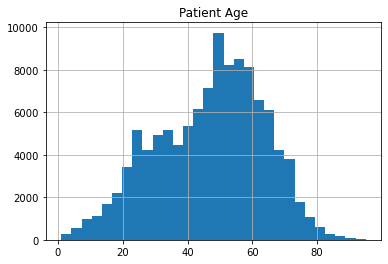

In [5]:
all_xray_df.hist('Patient Age', bins=30)

In [6]:
all_xray_df['Patient Age'].max()

95

## Gender

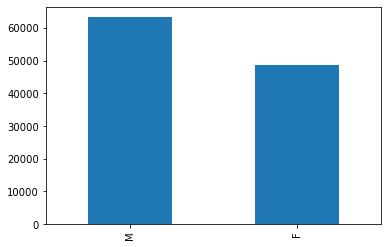

In [7]:
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

## Position for the view

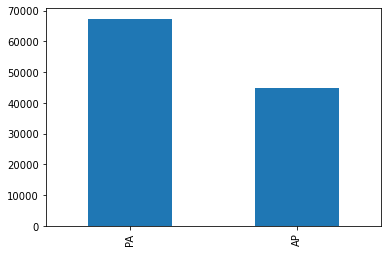

In [8]:
all_xray_df['View Position'].value_counts().plot(kind='bar')

## Follow up 


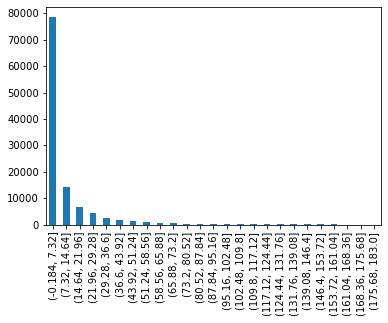

In [9]:
all_xray_df['Follow-up #'].value_counts(bins = 25).plot(kind='bar')

In [10]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
63360,00015646_032.png,Atelectasis|Emphysema|Pneumothorax,32,15646,66,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
977,00000244_001.png,No Finding,1,244,38,F,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
86972,00021457_040.png,Infiltration,40,21457,34,M,AP,2616,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


[Text(0, 0.5, 'Number of Images with Label')]

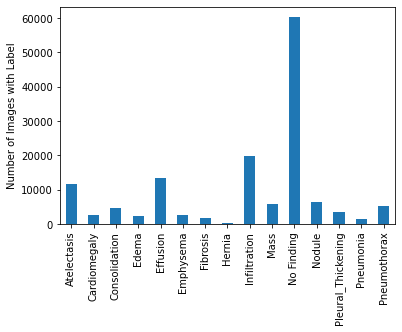

In [11]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [12]:
# Number of pneumonia cases / total p
pneumo_cases = len(all_xray_df[all_xray_df['Pneumonia'] == 1])/len(all_xray_df['Pneumonia'])
'the percentage of pneumonia cases over the total is : %s' % (pneumo_cases*100)

'the percentage of pneumonia cases over the total is : 1.2756012274316706'

Before the traning it will be important to rebalance the dataset as there are too few penumonia cases

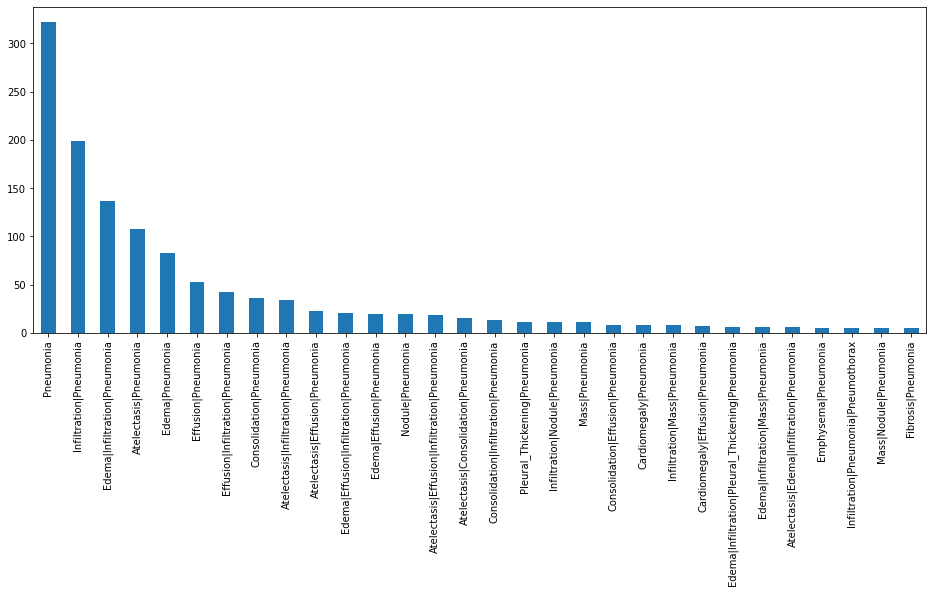

In [13]:
# Combination of potential findings
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

In [14]:
try1 = all_xray_df[all_xray_df['Finding Labels'].str.contains('Pneumonia')]
try2 = try1.iloc[:,12:27]
try2.drop('No Finding', axis=1, inplace = True)
try2['sum'] = try2.sum(axis=1)
num = len(try2[try2['sum'] == 1])/len(try2['sum'])
print(f'There are { num:.2%} patients with only pneumonia in the dataset so comorbidities would be important to investigate')

There are 22.52% patients with only pneumonia in the dataset so comorbidities would be important to investigate


Text(0.5, 1.0, 'Number of pneumonia patients relative to their age')

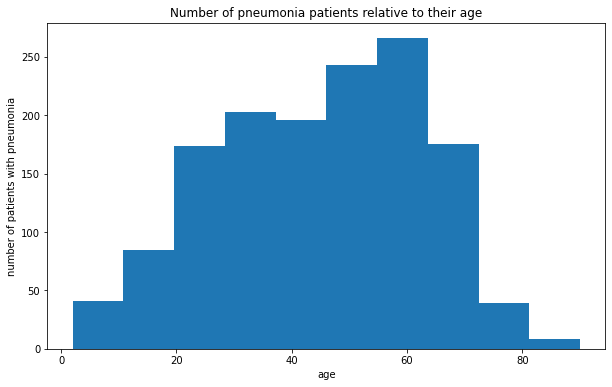

In [15]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])
plt.ylabel('number of patients with pneumonia')
plt.xlabel('age')
plt.title('Number of pneumonia patients relative to their age')

In [16]:
'The mean age is people with pneumonia is: %s years old' % (int(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'].mean()))

'The mean age is people with pneumonia is: 44 years old'

Text(0.5, 1.0, 'Number of pneumonia patients relative to their sex')

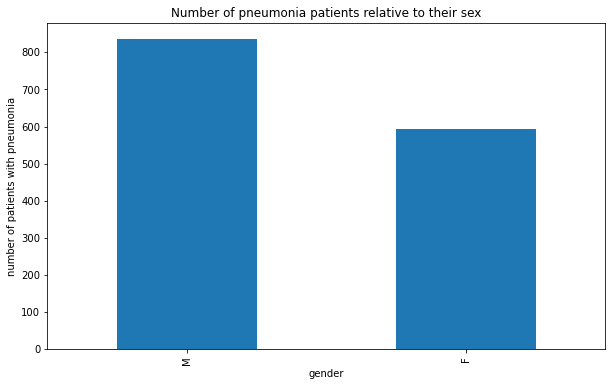

In [17]:
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.ylabel('number of patients with pneumonia')
plt.xlabel('gender')
plt.title('Number of pneumonia patients relative to their sex')

## Number of diseases by patient

In [18]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [19]:
df1 = all_xray_df.iloc[:,12:27].copy()
df1.drop('No Finding', axis= 1, inplace = True)
df1['sum'] = df1.sum(axis=1)

In [20]:
df1['age'] = all_xray_df['Patient Age']

Text(0.5, 1.0, 'Number of patients having diseases')

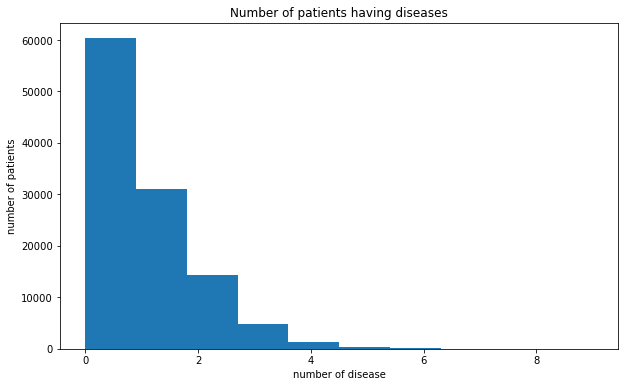

In [21]:
plt.figure(figsize=(10,6))
plt.hist(df1['sum'])
plt.ylabel('number of patients')
plt.xlabel('number of disease')
plt.title('Number of patients having diseases')

## Pixel investigation

In [22]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000032_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030712_000.png
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000,/data/images_012/images/00030786_005.png
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030789_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311,/data/images_012/images/00030792_000.png


In [23]:
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3078,00015167_002.png,Mass,2,15167,057Y,M,PA,2840,2936,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
852,00004435_020.png,Infiltration,20,4435,028Y,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4714,00024121_000.png,No Finding,0,24121,031Y,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [24]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
sample_df['pneumonia_class'] = np.where(sample_df['Pneumonia'] == 1, 'Pneumonia', 'No_pneumonia')

In [26]:
sample_df.drop('No Finding', axis=1, inplace = True)
sample_df['sum'] = sample_df.iloc[:,12:27].sum(axis=1)

In [27]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,sum
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,No_pneumonia,4.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia,2.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia,1.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia,0.0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia,3.0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia,1.0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_pneumonia,0.0


In [28]:
sample_df[(sample_df["Pneumonia"] == 1) & (sample_df["sum"] == 1)]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,sum
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
3593,00017714_019.png,Pneumonia,19,17714,020Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
3858,00019021_001.png,Pneumonia,1,19021,044Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
4033,00019865_013.png,Pneumonia,13,19865,022Y,M,PA,2786,2739,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
4282,00021127_018.png,Pneumonia,18,21127,065Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0


In [29]:
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)

In [30]:
hist = sample_df[(sample_df["Pneumonia"] == 1) & (sample_df["sum"] == 1)]
data = []
for p in range(9):
    data.append(("pneumonia", hist.iloc[p]["path_img"]))

In [31]:
data

[('pneumonia', '/data/images_004/images/00008470_008.png'),
 ('pneumonia', '/data/images_006/images/00011702_043.png'),
 ('pneumonia', '/data/images_006/images/00012158_025.png'),
 ('pneumonia', '/data/images_006/images/00012667_000.png'),
 ('pneumonia', '/data/images_006/images/00012733_000.png'),
 ('pneumonia', '/data/images_007/images/00014201_008.png'),
 ('pneumonia', '/data/images_008/images/00017714_019.png'),
 ('pneumonia', '/data/images_009/images/00019021_001.png'),
 ('pneumonia', '/data/images_009/images/00019865_013.png')]

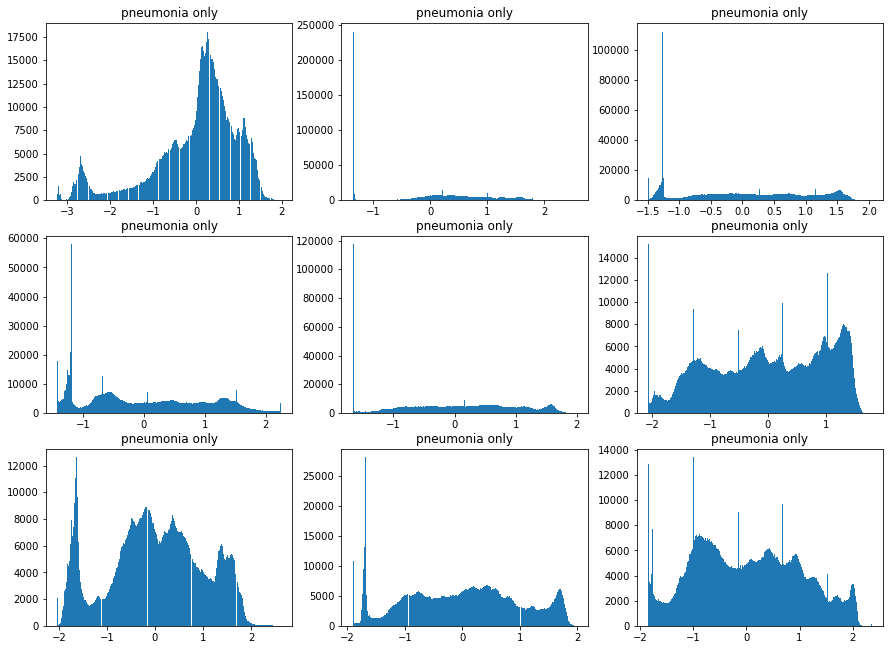

In [32]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('pneumonia only')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

In [33]:
hist = sample_df[sample_df["pneumonia_class"] == 'No_pneumonia']
data = []
for p in range(9):
    data.append(("pneumonia", hist.iloc[p]["path_img"]))

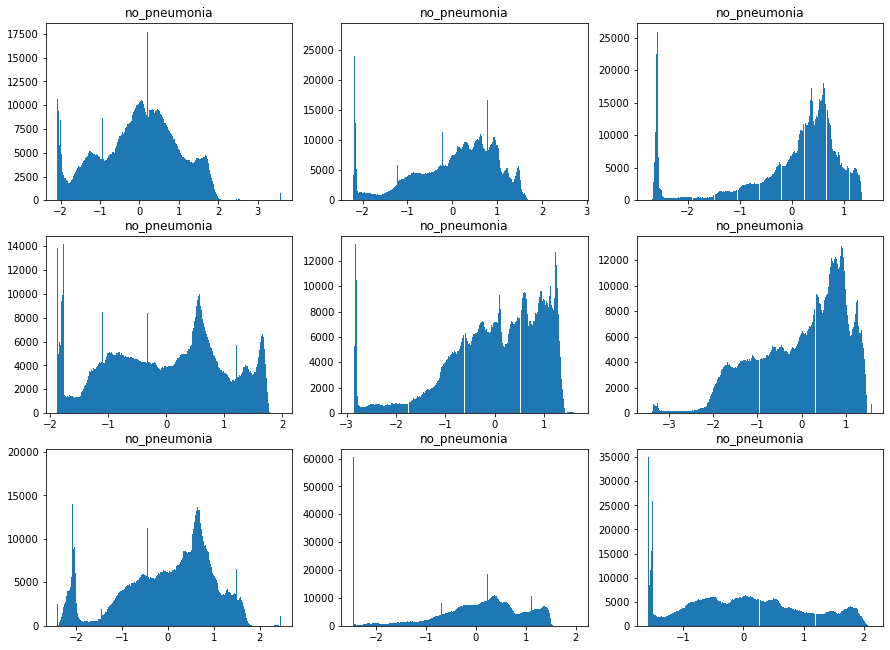

In [34]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('no_pneumonia')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

In [35]:
sample_df.iloc[:, 12:26]

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5602,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
hist = sample_df[sample_df["Infiltration"] ==1]
data = []
for p in range(9):
    data.append(("inflitration", hist.iloc[p]["path_img"]))

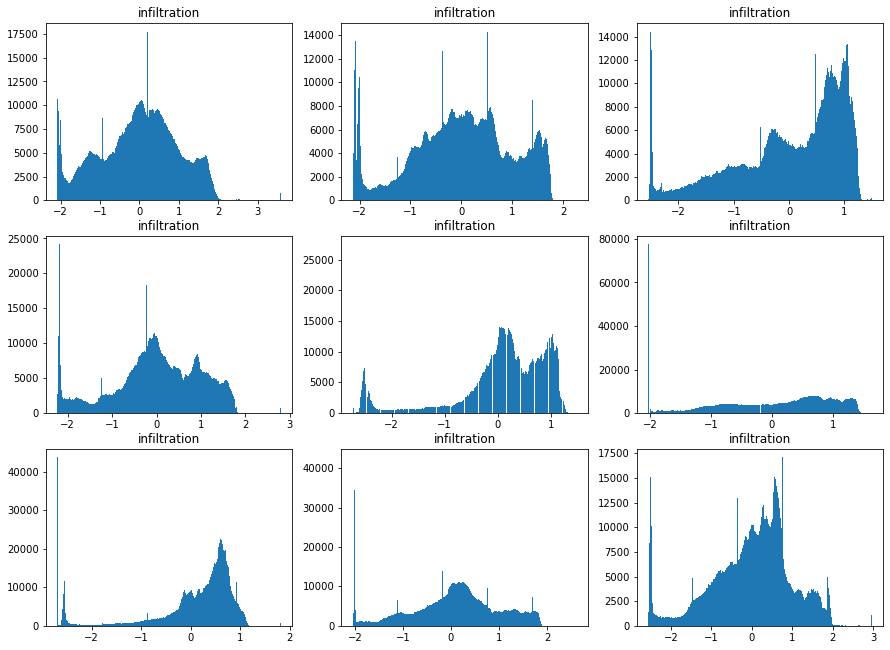

In [37]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('infiltration')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

In [44]:
sample_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'path', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax', 'pneumonia_class', 'sum', 'path_img'],
      dtype='object')

In [51]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


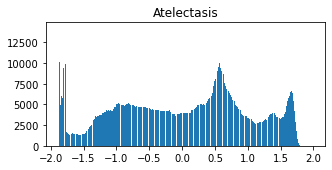

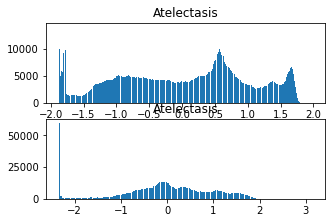

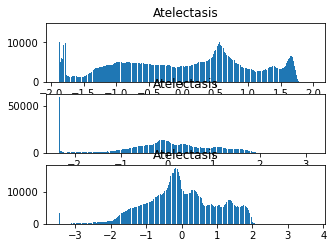

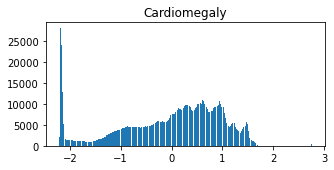

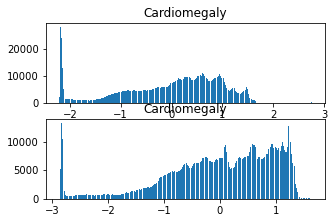

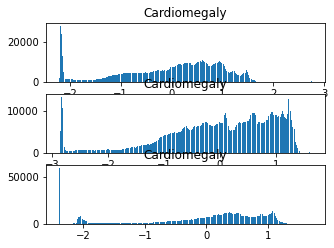

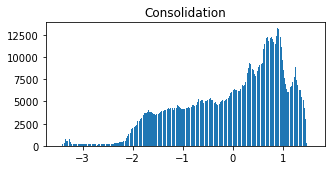

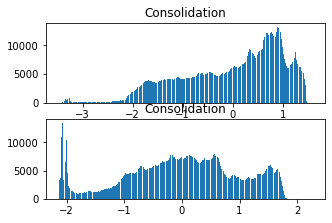

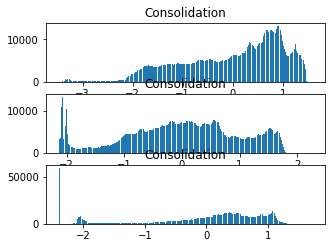

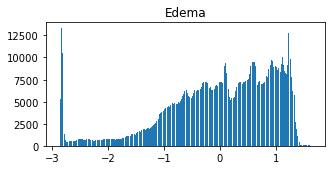

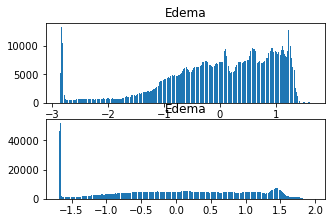

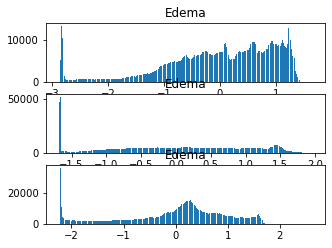

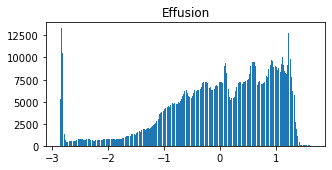

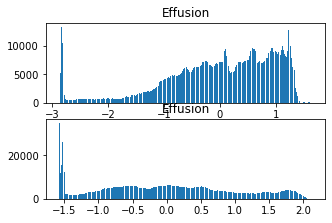

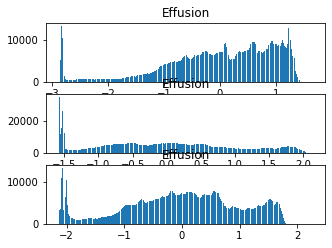

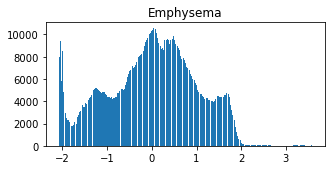

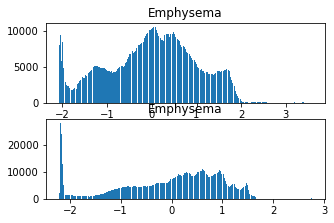

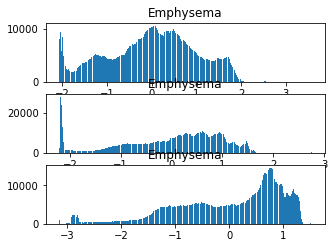

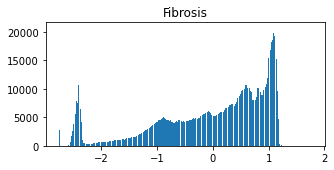

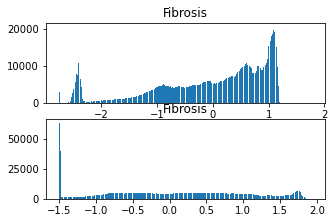

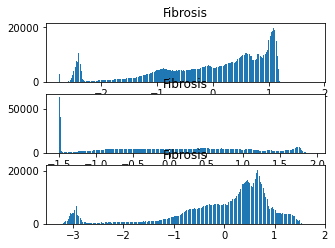

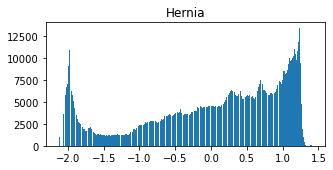

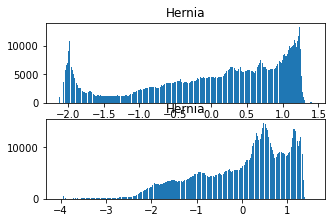

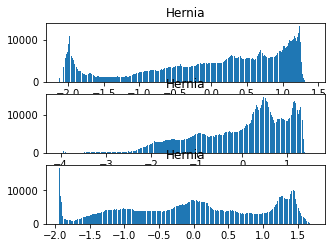

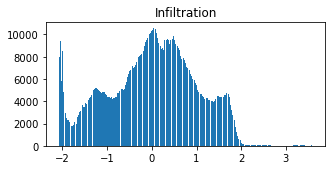

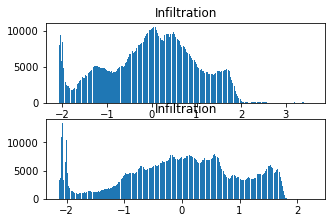

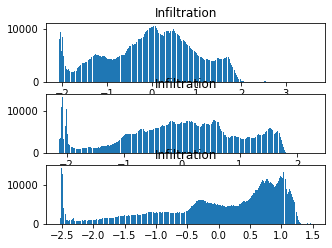

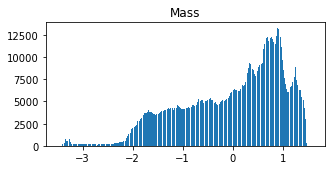

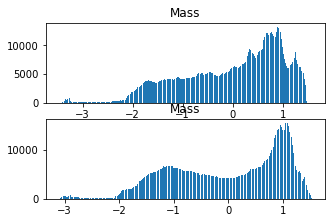

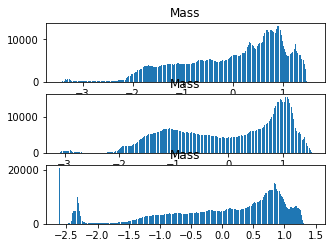

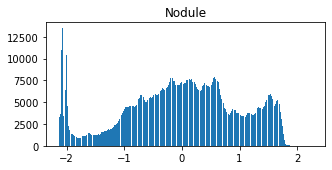

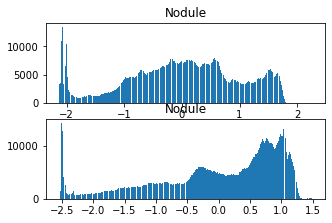

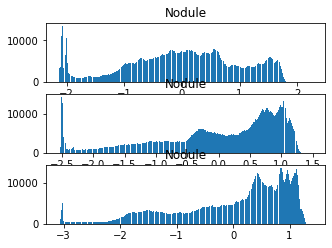

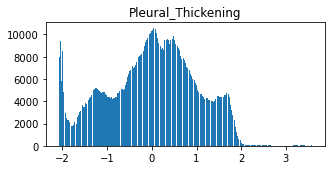

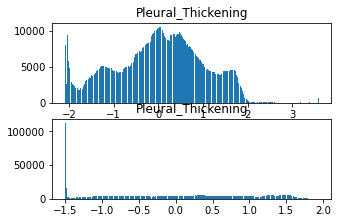

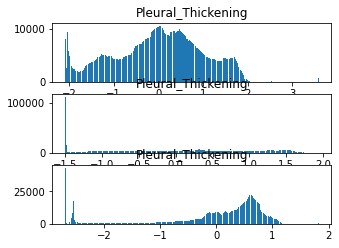

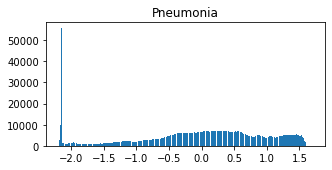

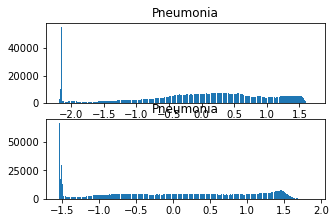

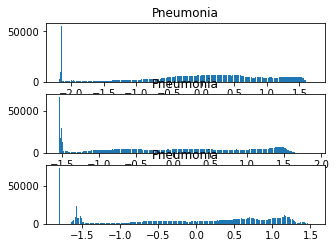

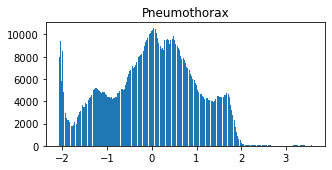

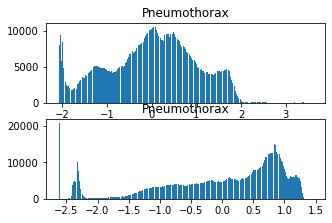

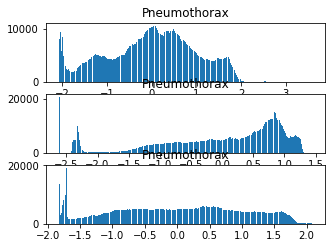

In [55]:
liste = ['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax']
for f in liste:
    hist = sample_df[sample_df[f] == 1]
    data = []
    for p in range(3):
        data.append((f, hist.iloc[p]["path_img"]))
        plt.figure(figsize=(5, 5))
        columns = 1
        for i in range(len(data) ):
            plt.subplot(len(data) / columns + 1, columns, i + 1).set_title(f)
            var = plt.imread(data[i][1])
            plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=300)

In [56]:
'We can see that pleural thickening and fibrosis can change the performance of the model due to their relative similarity with the pixel intensity distribution of pneumonia'

'We can see that pleural thickening and fibrosis can change the performance of the model due to their relative similarity with the pixel intensity distribution of pneumonia'

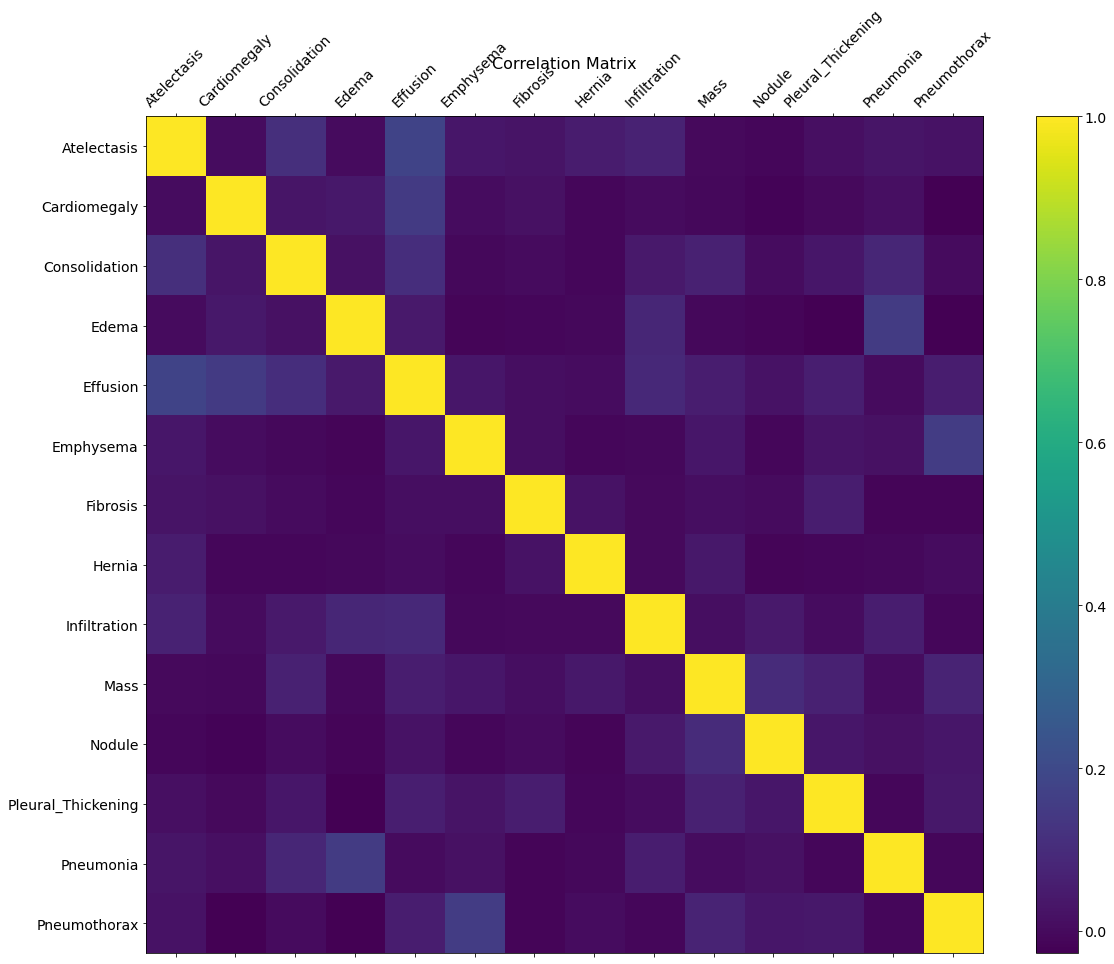

In [42]:
f = plt.figure(figsize=(19, 15))
plt.matshow(sample_df.iloc[:, 12:26].corr(), fignum=f.number)
plt.xticks(range(sample_df.iloc[:, 12:26].shape[1]), sample_df.iloc[:, 12:26].columns, fontsize=14, rotation=45)
plt.yticks(range(sample_df.iloc[:, 12:26].shape[1]), sample_df.iloc[:, 12:26].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
